# CIC prediction

In [1]:
from warnings import simplefilter
simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

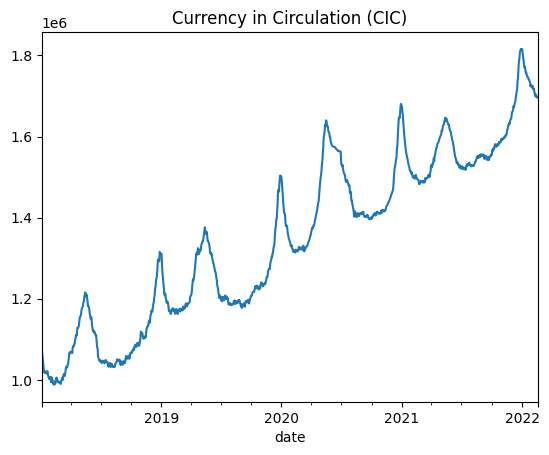

In [3]:
data = pd.read_excel('../data/CIC.xlsx', parse_dates=['date'], index_col='date')
data['CIC'].plot(title = 'Currency in Circulation (CIC)'); plt.show()

## Section 2: Model Definition

In [4]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS,
)
from sktime.forecasting.fbprophet import Prophet

In [5]:
ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=True, seasonal=True,
                    max_D = 262, max_p= 10, max_q=10),
    "AutoETS": StatsForecastAutoETS(season_length=262),
    "AutoCES": StatsForecastAutoCES(season_length=262),
    "AutoTheta": StatsForecastAutoTheta(season_length=262),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=262, 
                                        use_trend =True, use_boxcox=True),
    "Prophet": Prophet(yearly_seasonality=True, weekly_seasonality=True),
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'CIC',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

### Cross validation Procedure

In [ ]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')

model.plot_cv_procedure(xlabel='')

### Out-Of-sample Evaluation

In [ ]:
summary_horizon, summary_results = model.evaluate()

In [ ]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

In [ ]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

In [ ]:
subset = ['AutoETS', 'AutoCES', 'AutoTBATS', 'Prophet','Model Avg (all models)']
model.plot_model_compare(score ='MAPE', view = 'cutoff')#, model_subset=subset)
model.plot_model_compare(score ='MAE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])

In [ ]:
model.fit(verbose = True)
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='best_horizon', ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = None,
                     y_pred_interval = y_pred_ints)  

In [ ]:
model.get_pred_errors(verbose = True)

In [ ]:
path = '../model_output/CIC_forecast.pkl'
model.save(path)